Импорт библиотек

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
!pip install rdd
from rdd import rdd
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

%matplotlib inline

Загрузка данных

In [ ]:
data = pd.read_stata('/content/lee-data.dta')
data = data[data['party'] == 100]
data.head()

,state,distnum,distid,party,partname,yearel,origvote,totvote,highestvote,sechighestvote,uniqid,officeexp
0,1,1,1,100,,1946,82231.0,175237.0,93006.0,82231.0,15937,0
2,1,1,1,100,,1948,127802.0,233700.0,127802.0,103294.0,23403,0
4,1,1,1,100,,1950,134258.0,231096.0,134258.0,96251.0,23403,1
6,1,1,1,100,,1952,160080.0,296620.0,160080.0,136540.0,8243,0
8,1,1,1,100,,1954,148935.0,261461.0,148935.0,112526.0,8243,1


Преобразование данных и проверка sharp RDD design

<Axes: xlabel='dem_margin', ylabel='treatment'>

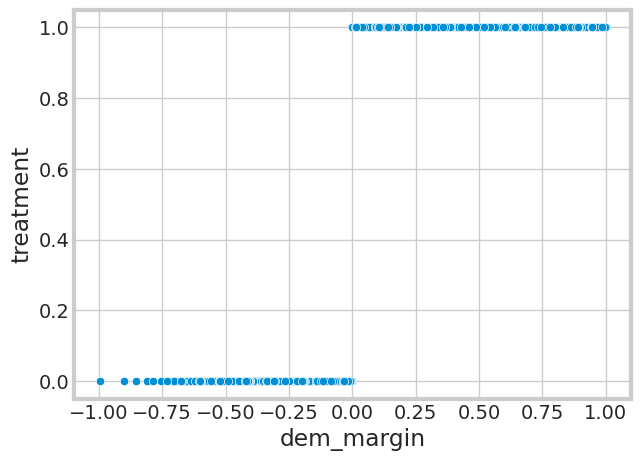

In [ ]:
def calculate_dem_margin(row):
    if row['origvote'] == row['highestvote']:
        return (row['origvote'] - row['sechighestvote']) / row['totvote']
    else:
        return (row['origvote'] - row['highestvote']) / row['totvote']

def calculate_treatment(row):
    if row['origvote'] == row['highestvote']:
        return 1
    else:
        return 0

data['dem_margin'] = data.apply(calculate_dem_margin, axis=1)
data['treatment'] = data.apply(calculate_treatment, axis=1)

sns.scatterplot(data = data, x='dem_margin', y='treatment')

In [ ]:
data['vote_share'] = data.apply(lambda row: row['origvote'] / row['totvote'], axis=1)
data = data.sort_values(by='yearel')
data['dem_margin_2'] = data.groupby(['state', 'distnum', 'distid', 'party'])['dem_margin'].shift(1)
data.head()

,state,distnum,distid,party,partname,yearel,origvote,totvote,highestvote,sechighestvote,uniqid,officeexp,dem_margin,treatment,vote_share,dem_margin_2
0,1,1,1,100,,1946,82231.0,175237.0,93006.0,82231.0,15937,0,-0.061488,0,0.469256,NaN
11063,40,5,268,100,,1946,17741.0,24131.0,17741.0,6390.0,27319,0,0.470391,1,0.735195,NaN
1279,12,2,33,100,,1946,26740.0,81251.0,54511.0,26740.0,15225,0,-0.341793,0,0.329104,NaN
11027,40,4,267,100,,1946,13636.0,15648.0,13636.0,2012.0,8633,0,0.742843,1,0.871421,NaN
10985,40,3,266,100,,1946,21947.0,29921.0,21947.0,7974.0,10816,0,0.466996,1,0.733498,NaN


<Axes: xlabel='dem_margin_2', ylabel='vote_share'>

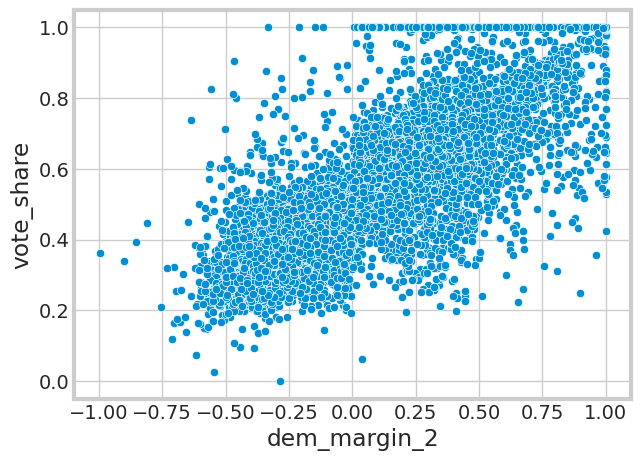

In [ ]:
sns.scatterplot(data = data, x='dem_margin_2', y='vote_share')

<Axes: xlabel='dem_margin_2', ylabel='vote_share'>

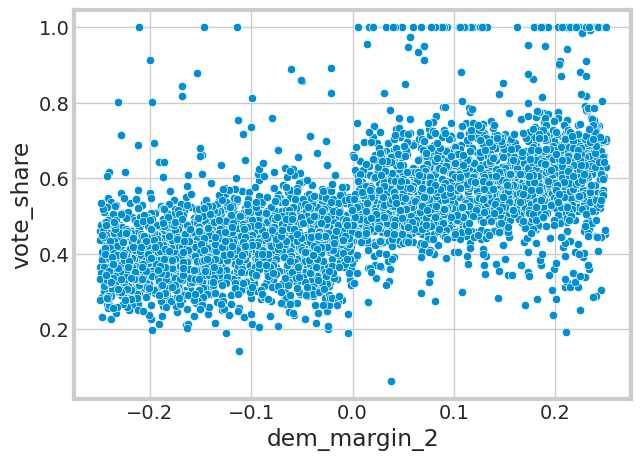

In [ ]:
data = data[data['dem_margin_2'] <= 0.25]
data = data[data['dem_margin_2'] >= -0.25]
sns.scatterplot(data = data, x='dem_margin_2', y='vote_share')

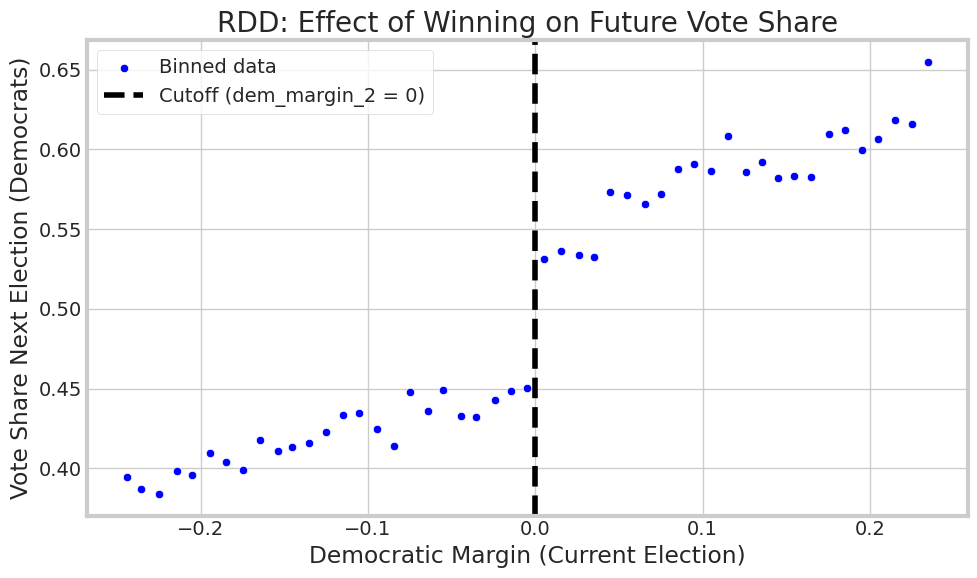

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Функция для биннинга данных
bin_width = 0.01
bins = np.arange(data['dem_margin_2'].min(), data['dem_margin_2'].max(), bin_width)
data['bin'] = pd.cut(data['dem_margin_2'], bins=bins)

# Усреднение по бинам
binned_data = data.groupby('bin', observed=True).agg(
    x_mean=('dem_margin_2', 'mean'),
    y_mean=('vote_share', 'mean'),
    count=('vote_share', 'count')
).reset_index()

# Отсеиваем бины с малым количеством наблюдений
binned_data = binned_data[binned_data['count'] > 5]

# Разделяем данные на левую и правую часть от точки разрыва
cutoff = 0
left_mask = binned_data['x_mean'] < cutoff
right_mask = binned_data['x_mean'] >= cutoff

# Обучаем модели регрессии
model_left = LinearRegression().fit(
    binned_data[left_mask]['x_mean'].values.reshape(-1,1),
    binned_data[left_mask]['y_mean']
)
model_right = LinearRegression().fit(
    binned_data[right_mask]['x_mean'].values.reshape(-1,1),
    binned_data[right_mask]['y_mean']
)

# Генерируем предсказания
x_left = np.linspace(binned_data['x_mean'].min(), cutoff, 100)

x_right = np.linspace(cutoff, binned_data['x_mean'].max(), 100)

# Рисуем график
sns.scatterplot(
    data=binned_data,
    x='x_mean',
    y='y_mean',
    color='blue',
    label='Binned data'
)

plt.axvline(
    x=0,
    color='black',
    linestyle='--',
    label='Cutoff (dem_margin_2 = 0)'
)


# Подписи и легенда
plt.xlabel('Democratic Margin (Current Election)')
plt.ylabel('Vote Share Next Election (Democrats)')
plt.title('RDD: Effect of Winning on Future Vote Share')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model = rdd.rdd(data, 'dem_margin_2', 'vote_share', cut=0)
print(model.fit().summary())

Estimation Equation:	 vote_share ~ TREATED + dem_margin_2
                            WLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.405
Model:                            WLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     1406.
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:37:23   Log-Likelihood:                 3461.1
No. Observations:                4133   AIC:                            -6916.
Df Residuals:                    4130   BIC:                            -6897.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
rdd_df = data.assign(threshold=(data['dem_margin_2'] > 0).astype(int))

model = smf.wls("vote_share~dem_margin_2*threshold", rdd_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             vote_share   R-squared:                       0.406
Model:                            WLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     942.6
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:30:56   Log-Likelihood:                 3465.9
No. Observations:                4133   AIC:                            -6924.
Df Residuals:                    4129   BIC:                            -6898.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.4521      0.005     99.530      0.000       0.443       0.461
dem_margin_2               0.2565      0.032      8.036      0.000       0.194       0.319
threshold                  0.0857      0.006     13.194      0.000       0.073       0.098
dem_margin_2:threshold     0.1400      0.045      3.084      0.002       0.051       0.229
==============================================================================
Omnibus:                      919.029   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3827.333
Skew:                           1.033   Prob(JB):                         0.00
Kurtosis:                       7.237   Cond. No.                         36.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
rdd_df = binned_data.assign(threshold=(binned_data['x_mean'] > 0).astype(int))

model = smf.wls("y_mean~x_mean*threshold", rdd_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 y_mean   R-squared:                       0.984
Model:                            WLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     943.8
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           1.27e-40
Time:                        18:37:27   Log-Likelihood:                 152.48
No. Observations:                  49   AIC:                            -297.0
Df Residuals:                      45   BIC:                            -289.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4518      0.004    100.538      0.000       0.443       0.461
x_mean               0.2555      0.031      8.191      0.000       0.193       0.318
threshold            0.0868      0.006     13.495      0.000       0.074       0.100
x_mean:threshold     0.1282      0.046      2.814      0.007       0.036       0.220
==============================================================================
Omnibus:                        1.277   Durbin-Watson:                   1.468
Prob(Omnibus):                  0.528   Jarque-Bera (JB):                1.191
Skew:                           0.361   Prob(JB):                        0.551
Kurtosis:                       2.753   Cond. No.                         36.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

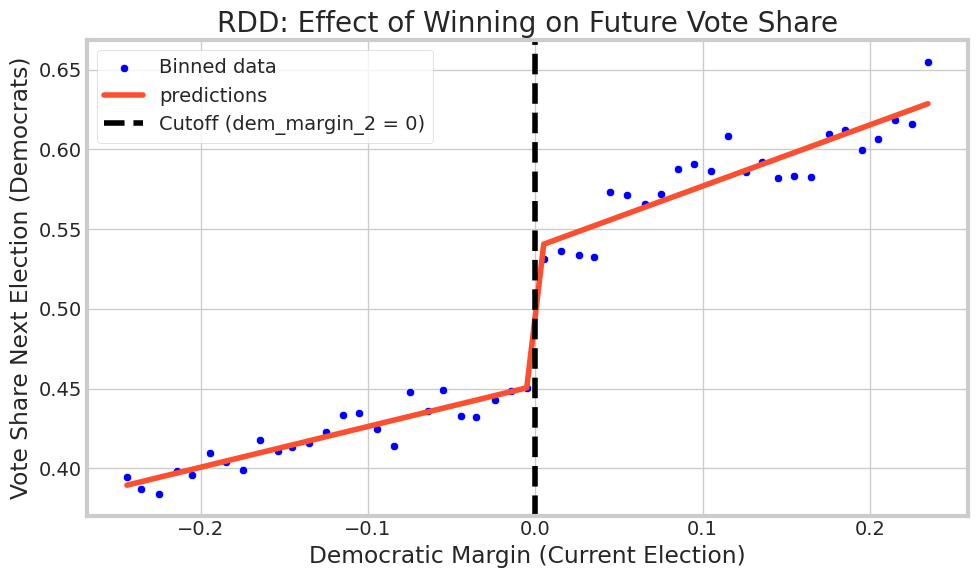

In [ ]:
# Рисуем график
# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.scatterplot(
    data=binned_data,
    x='x_mean',
    y='y_mean',
    color='blue',
    label='Binned data'
)
binned_data.assign(predictions=model.fittedvalues).plot(x="x_mean", y="predictions", ax=ax, color="C1")
plt.axvline(
    x=0,
    color='black',
    linestyle='--',
    label='Cutoff (dem_margin_2 = 0)'
)


# Подписи и легенда
plt.xlabel('Democratic Margin (Current Election)')
plt.ylabel('Vote Share Next Election (Democrats)')
plt.title('RDD: Effect of Winning on Future Vote Share')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
data = data.sort_values(by='yearel')
data['vote_share_2'] = data.groupby(['state', 'distnum', 'distid', 'party'])['vote_share'].shift(-1)
data.head()

,state,distnum,distid,party,partname,yearel,origvote,totvote,highestvote,sechighestvote,uniqid,officeexp,dem_margin,treatment,vote_share,dem_margin_2,bin,vote_share_2
1686,12,10,41,100,,1948,58668.0,115706.0,58668.0,52898.0,23792,0,0.049868,1,0.507044,-0.067390,"(-0.0698, -0.0598]",0.610147
6280,22,1,152,100,,1948,78898.0,130085.0,78898.0,50194.0,17524,1,0.220656,1,0.606511,0.051426,"(0.0502, 0.0602]",0.525558
6599,22,7,158,100,,1948,74396.0,138600.0,74396.0,62855.0,20733,0,0.083268,1,0.536768,-0.029914,"(-0.0398, -0.0298]",0.493257
16893,64,1,446,100,,1948,64276.0,94714.0,64276.0,29937.0,17725,1,0.362555,1,0.678633,0.151258,"(0.15, 0.16]",0.503186
7069,23,6,168,100,,1948,72681.0,147554.0,73465.0,72681.0,27533,0,-0.005313,0,0.492572,-0.153454,"(-0.16, -0.15]",0.463126


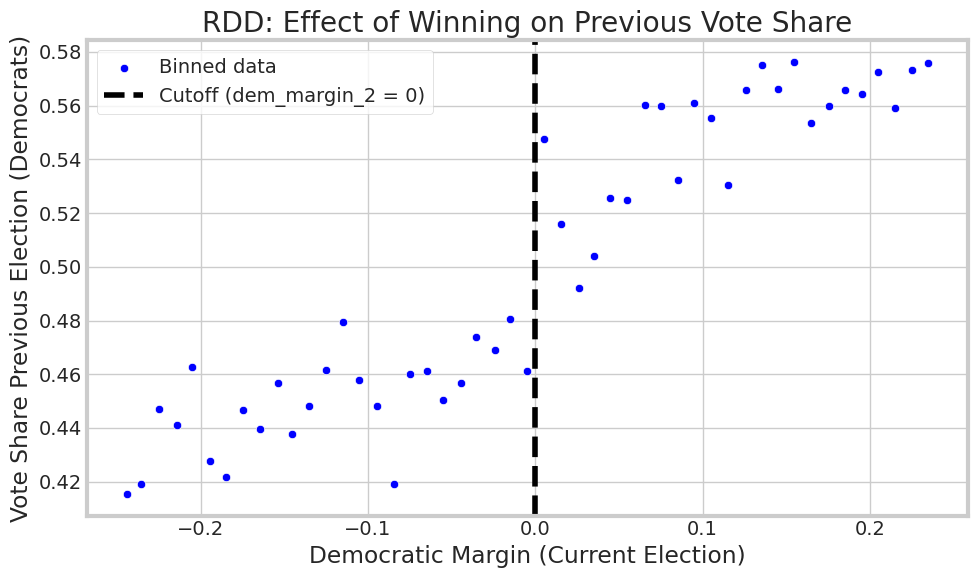

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Функция для биннинга данных
bin_width = 0.01
bins = np.arange(data['dem_margin_2'].min(), data['dem_margin_2'].max(), bin_width)
data['bin'] = pd.cut(data['dem_margin_2'], bins=bins)

# Усреднение по бинам
binned_data = data.groupby('bin', observed=True).agg(
    x_mean=('dem_margin_2', 'mean'),
    y_mean=('vote_share_2', 'mean'),
    count=('vote_share_2', 'count')
).reset_index()

# Отсеиваем бины с малым количеством наблюдений
binned_data = binned_data[binned_data['count'] > 5]

# Разделяем данные на левую и правую часть от точки разрыва
cutoff = 0
left_mask = binned_data['x_mean'] < cutoff
right_mask = binned_data['x_mean'] >= cutoff

# Обучаем модели регрессии
model_left = LinearRegression().fit(
    binned_data[left_mask]['x_mean'].values.reshape(-1,1),
    binned_data[left_mask]['y_mean']
)
model_right = LinearRegression().fit(
    binned_data[right_mask]['x_mean'].values.reshape(-1,1),
    binned_data[right_mask]['y_mean']
)

# Генерируем предсказания
x_left = np.linspace(binned_data['x_mean'].min(), cutoff, 100)

x_right = np.linspace(cutoff, binned_data['x_mean'].max(), 100)

# Рисуем график
sns.scatterplot(
    data=binned_data,
    x='x_mean',
    y='y_mean',
    color='blue',
    label='Binned data'
)

plt.axvline(
    x=0,
    color='black',
    linestyle='--',
    label='Cutoff (dem_margin_2 = 0)'
)


# Подписи и легенда
plt.xlabel('Democratic Margin (Current Election)')
plt.ylabel('Vote Share Previous Election (Democrats)')
plt.title('RDD: Effect of Winning on Previous Vote Share')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
rdd_df = data.assign(threshold=(data['dem_margin_2'] > 0).astype(int))

model = smf.wls("vote_share_2~dem_margin_2*threshold", rdd_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:           vote_share_2   R-squared:                       0.154
Model:                            WLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     220.0
Date:                Wed, 26 Mar 2025   Prob (F-statistic):          4.04e-131
Time:                        18:41:09   Log-Likelihood:                 2470.9
No. Observations:                3639   AIC:                            -4934.
Df Residuals:                    3635   BIC:                            -4909.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.4703      0.006     83.044      0.000       0.459       0.481
dem_margin_2               0.1659      0.040      4.128      0.000       0.087       0.245
threshold                  0.0510      0.008      6.320      0.000       0.035       0.067
dem_margin_2:threshold     0.0735      0.057      1.289      0.198      -0.038       0.185
==============================================================================
Omnibus:                      454.234   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1049.356
Skew:                           0.734   Prob(JB):                    1.37e-228
Kurtosis:                       5.183   Cond. No.                         36.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

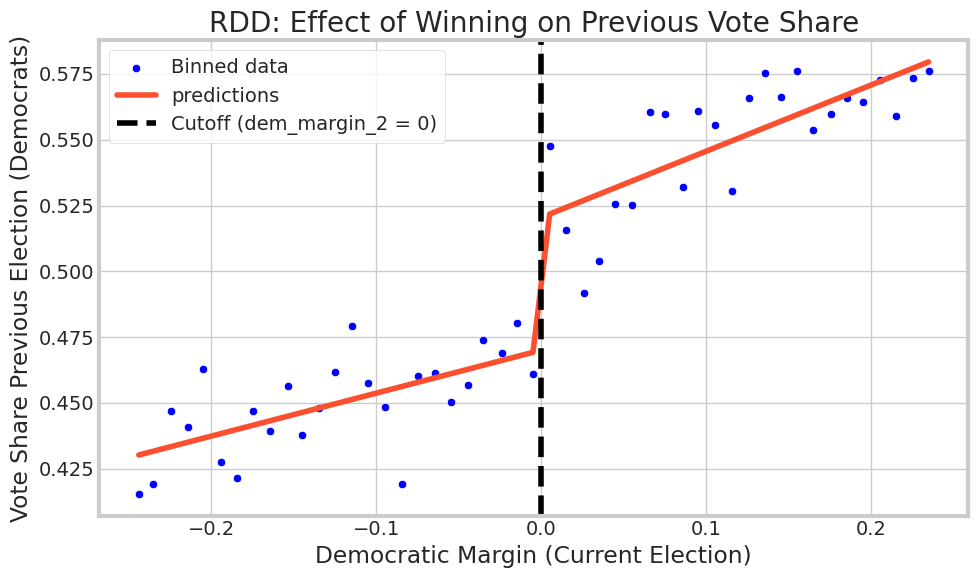

In [ ]:
rdd_df = binned_data.assign(threshold=(binned_data['x_mean'] > 0).astype(int))

model = smf.wls("y_mean~x_mean*threshold", rdd_df).fit()
# Рисуем график
# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.scatterplot(
    data=binned_data,
    x='x_mean',
    y='y_mean',
    color='blue',
    label='Binned data'
)
binned_data.assign(predictions=model.fittedvalues).plot(x="x_mean", y="predictions", ax=ax, color="C1")
plt.axvline(
    x=0,
    color='black',
    linestyle='--',
    label='Cutoff (dem_margin_2 = 0)'
)


# Подписи и легенда
plt.xlabel('Democratic Margin (Current Election)')
plt.ylabel('Vote Share Previous Election (Democrats)')
plt.title('RDD: Effect of Winning on Previous Vote Share')
plt.legend()

plt.tight_layout()
plt.show()

Плацебо тест

In [ ]:
data = data.sort_values(by='yearel')
data['officeexp_2'] = data.groupby(['state', 'distnum', 'distid', 'party'])['officeexp'].shift(1)
data.head()

,state,distnum,distid,party,partname,yearel,origvote,totvote,highestvote,sechighestvote,uniqid,officeexp,dem_margin,treatment,vote_share,dem_margin_2,bin,vote_share_2,officeexp_2
1686,12,10,41,100,,1948,58668.0,115706.0,58668.0,52898.0,23792,0,0.049868,1,0.507044,-0.067390,"(-0.0698, -0.0598]",0.610147,NaN
16702,62,4,441,100,,1948,34695.0,66901.0,34695.0,32206.0,2174,0,0.037204,1,0.518602,-0.174935,"(-0.18, -0.17]",0.573018,NaN
8832,25,1,208,100,,1948,61791.0,129782.0,67387.0,61791.0,12687,0,-0.043118,0,0.476114,-0.137083,"(-0.14, -0.13]",0.428151,NaN
305,1,98,7,100,,1948,429348.0,879351.0,433311.0,429348.0,28759,0,-0.004507,0,0.488256,-0.147257,"(-0.15, -0.14]",0.485531,NaN
16283,56,4,429,100,,1948,72378.0,136379.0,72378.0,64001.0,4956,0,0.061424,1,0.530712,-0.052942,"(-0.0598, -0.0498]",0.516450,NaN


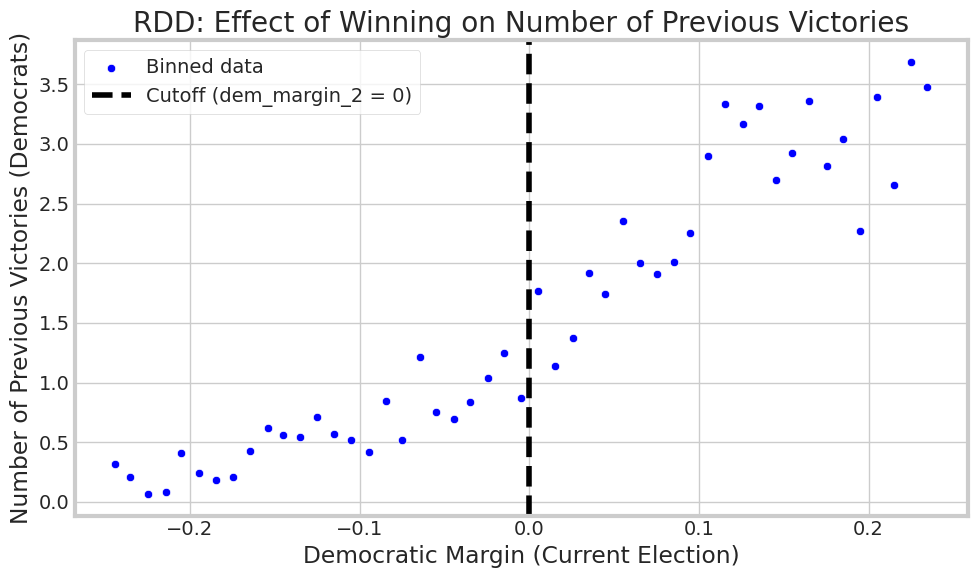

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Функция для биннинга данных
bin_width = 0.01
bins = np.arange(data['dem_margin_2'].min(), data['dem_margin_2'].max(), bin_width)
data['bin'] = pd.cut(data['dem_margin_2'], bins=bins)

# Усреднение по бинам
binned_data = data.groupby('bin', observed=True).agg(
    x_mean=('dem_margin_2', 'mean'),
    y_mean=('officeexp_2', 'mean'),
    count=('officeexp_2', 'count')
).reset_index()

# Отсеиваем бины с малым количеством наблюдений
binned_data = binned_data[binned_data['count'] > 5]

# Разделяем данные на левую и правую часть от точки разрыва
cutoff = 0
left_mask = binned_data['x_mean'] < cutoff
right_mask = binned_data['x_mean'] >= cutoff

# Обучаем модели регрессии
model_left = LinearRegression().fit(
    binned_data[left_mask]['x_mean'].values.reshape(-1,1),
    binned_data[left_mask]['y_mean']
)
model_right = LinearRegression().fit(
    binned_data[right_mask]['x_mean'].values.reshape(-1,1),
    binned_data[right_mask]['y_mean']
)

# Генерируем предсказания
x_left = np.linspace(binned_data['x_mean'].min(), cutoff, 100)

x_right = np.linspace(cutoff, binned_data['x_mean'].max(), 100)

# Рисуем график
sns.scatterplot(
    data=binned_data,
    x='x_mean',
    y='y_mean',
    color='blue',
    label='Binned data'
)

plt.axvline(
    x=0,
    color='black',
    linestyle='--',
    label='Cutoff (dem_margin_2 = 0)'
)


# Подписи и легенда
plt.xlabel('Democratic Margin (Current Election)')
plt.ylabel('Number of Previous Victories (Democrats)')
plt.title('RDD: Effect of Winning on Number of Previous Victories')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
rdd_df = data.assign(threshold=(data['dem_margin_2'] > 0).astype(int))

model = smf.wls("officeexp_2~dem_margin_2*threshold", rdd_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:            officeexp_2   R-squared:                       0.172
Model:                            WLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     251.8
Date:                Wed, 26 Mar 2025   Prob (F-statistic):          1.80e-148
Time:                        18:58:52   Log-Likelihood:                -8392.6
No. Observations:                3639   AIC:                         1.679e+04
Df Residuals:                    3635   BIC:                         1.682e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.0262      0.112      9.181      0.000       0.807       1.245
dem_margin_2               3.7669      0.791      4.763      0.000       2.216       5.318
threshold                  0.5156      0.160      3.230      0.001       0.203       0.829
dem_margin_2:threshold     4.6386      1.124      4.127      0.000       2.435       6.842
==============================================================================
Omnibus:                     2036.801   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17531.062
Skew:                           2.567   Prob(JB):                         0.00
Kurtosis:                      12.448   Cond. No.                         36.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""